# RFM segmentation
## Introduction
### Purpose of this notebook

The objective of this notebook is tu use the transactional data available to define a
risk segmentation of all customers. The segmentation should include 4 risk classes -
A, B, C, and D - where A represents the least risky customers and D represents the
most risky customers.

To implement microcredit properly, applicants' credit should be evaluated carefully
Practically, this means to assign for each applicant a credit score. This is a process
typically referred to as credit scoring and is the key for successful microcredit (Ryals et al., 2002)

### Predicament
Microcredit refers to small loans to borrowers who typically lack of collateral, steady employment or a verifiable credit history.
To replace this collateral, various sources of data that could be used for evaluation. Among them, the bank card transaction records play
an important role. 
This type of data can be limiting for credit scoring purpose:
- No historical dependent variable to generate regressions on
- No collateral data, socio demographic data or personal data

To overcome these limitation, we chose to generate a segmentation based on meaningful and useful features derivedfrom
historical transaction data.


### Proposed solution
The chosen approach is to focus on the variable construction process instead of general modeling methodology.
This approach is inspired by the popularly used RFM model for analyzing customer value in database marketing.
- R refers to recency, which means how recently a customer purchases. 
- F stands for frequency, which means how often a customer purchases. 
- M is the monetary value, which indicates how much a customer spends. 

Additionaly, the add of Clumpiness will be evaluated. 
- C refers for Clumpiness Factor: The clumpiness factor measures the concentration of purchases in a given time period. It helps to identify customers who make large purchases in a short period of time, rather than spreading out their purchases over a longer period. A high clumpiness factor indicates that a customer makes purchases in large, concentrated amounts, which may indicate an increased risk of default.


The combination of the RFM study and the clumpiness factor allows a company to take into account both the value and behavior of its customers, providing a more complete picture of their credit risk. This information can help the company make more informed decisions about its credit offering, reducing the risk of loan default and improving the management of its loan portfolio.

In [29]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import datetime as dt
import os
import pickle

#Plots
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.colors import n_colors
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns


#Clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#Stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import shapiro
from statsmodels.stats.multicomp import MultiComparison
from scipy import stats
import scikit_posthocs as sp


## Data
### Exploration

In [30]:
#Import the data
df_transaction = pd.read_csv('data\data_sample_technical_assignement.csv')
df_transaction.shape

#Searching for Missings,type of data and also known the shape of data
print('------------- dataset information -----------\n\n')
print(df_transaction.info())
#Looking unique values
print('------------- unique values -----------\n\n')
print(df_transaction.nunique())
#Looking at the general figures of the values
print('------------- data description -----------\n\n')
print(df_transaction.describe())
#Looking at missing values
print('------------- null values -----------\n\n')
print(df_transaction.isna().sum())
#Check the transasction with negative value, they might be returns
print('------------- negative quantities -----------\n\n')
df_transaction.loc[df_transaction['quantity']<=0]

------------- dataset information -----------


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155616 entries, 0 to 155615
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   product_id            155616 non-null  int64 
 1   sale_date             155616 non-null  object
 2   customer_id           155616 non-null  int64 
 3   quantity              155616 non-null  int64 
 4   total_amount          155616 non-null  int64 
 5   is_app_order          154982 non-null  object
 6   is_call_center_order  154982 non-null  object
 7   is_visit_order        154982 non-null  object
 8   category_id           155616 non-null  int64 
dtypes: int64(5), object(4)
memory usage: 10.7+ MB
None
------------- unique values -----------


product_id               543
sale_date                351
customer_id              921
quantity                  61
total_amount            1305
is_app_order               2
is_call_c

,product_id,sale_date,customer_id,quantity,total_amount,is_app_order,is_call_center_order,is_visit_order,category_id
28290,1901,2021-06-07,274804,-2,13550,False,True,False,232
68695,2057,2021-06-21,423995,-1,8850,False,False,True,240


### Cleaning

In [31]:
# Drop the returns since there are only 2 rows in the dataset
df_transaction = df_transaction.loc[df_transaction['quantity']>0]

#Transform the date column into date object
df_transaction["date"]= pd.to_datetime(df_transaction["sale_date"])

array([[<AxesSubplot: title={'center': 'quantity'}>,
        <AxesSubplot: title={'center': 'total_amount'}>, <AxesSubplot: >,
        <AxesSubplot: >],
       [<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
        <AxesSubplot: >]], dtype=object)

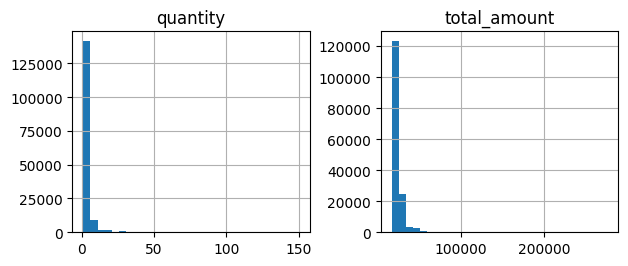

In [32]:
df_transaction[['quantity', 'total_amount']].hist(bins=30, figsize=(15, 6), layout=(2, 4))

## RFM analysis
### Recency
Recency is defined by the number of days separating the lastest purchase of a customer from the day of analysis. Here we assume that the day of the analysis corresponds to the latest date of the dataset.
Customers with a small R are often regarded as relatively active applicants.

In [33]:
#Assess the first and last date of the dataset
print('Min date: ', df_transaction['date'].min(), '\nMax date: ', df_transaction['date'].max())

Min date:  2020-10-12 00:00:00 
Max date:  2021-12-14 00:00:00


In [34]:
#Compute the recency factor
grouped = df_transaction.groupby('customer_id')
#Generate the aggregations grouped by user
df_grouped = grouped['date'].agg(['max', 'min', 'nunique'])
df_grouped = df_grouped.rename(columns={
    'max': 'last_purchase',
    'min': 'first_purchase',
    'nunique': 'number_purchase'
    })
df_grouped['recency'] = df_transaction['date'].max() - df_grouped['last_purchase'] #We assumed that recency is based on the latest date of the dataset
df_grouped['recency'] = df_grouped['recency'].apply(lambda x : x.days)

### Frequency
Frequency defines how many times a customer bought a product. For this, we assume the frequency is defined by the number of purchase per day since the first day of the account creation (first purchase of the customer)
Typically, the higher the frequency of purchase, the more loyal the customers are.

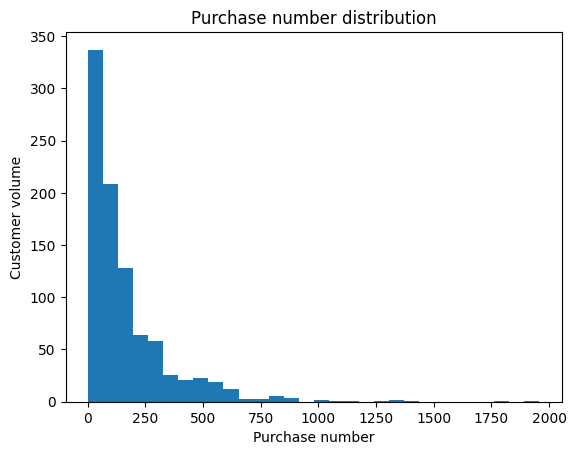

In [35]:
#Count the number of purchase per user
count_purchase = df_transaction.groupby('customer_id').count()['date']
plt.hist(count_purchase, bins=30)
plt.xlabel('Purchase number')
plt.ylabel('Customer volume')
plt.title('Purchase number distribution')
plt.show()

In [36]:
#Compute the frequency factor
df_grouped['existence'] = df_transaction['date'].max() - df_grouped['first_purchase']
df_grouped['existence'] = df_grouped['existence'].apply(lambda x : x.days)
df_grouped['frequency'] = df_grouped['number_purchase']/df_grouped['existence'] #Frequency is computed as number of purchase per day

### Monetary
Monetary characteristic corrspond to the total amounnt spent by the customer over its lifetime.

In [37]:
#Compute the monetary factor
df_montetary = grouped['total_amount'].agg(['sum']).rename(columns={'sum': 'monetary'})

### Clumpiness

Zhang et al. (2015) proposed a new individual-level measure of a customer’s history, (C) clumpiness—defined
as the degree of nonconformity to equal spacing—and. This study demonstrated its properties as an important component in the better understanding of Customer Life-Time Value and its subcomponents

The logic first groups the transactions by user and computes the entropy of the distribution of time between transactions using the formula:
-np.sum(np.diff(np.sort(x)) / np.timedelta64(1, 'D') * np.log2(np.diff(np.sort(x)) / np.timedelta64(1, 'D'))) / len(x)

The entropy is then normalized by dividing by the number of transactions for each user. The result is a new dataframe with a 'clumpiness' column that represents the clumpiness of each user's transactions.

A clumpiness profile with low clumpiness (i.e., close to negative infinity) might indicate that a user has low transaction frequency and transactions are spread out over a long time period, which could indicate lower risk. On the other hand, a clumpiness profile with high clumpiness (i.e., close to zero) might indicate that a user is making transactions frequently and transactions are clustered together, which could indicate higher risk

In [38]:
# Create a new dataframe with the clumpiness of each user
df_clumpiness = df_transaction.groupby('customer_id')['date'].apply(
    lambda x: -np.sum(
        np.diff(np.sort(x)) / np.timedelta64(1, 'D') * np.log2(np.diff(np.sort(x)) / np.timedelta64(1, 'D') + 1e-10)
        ) / len(x))
df_clumpiness = df_clumpiness.reset_index().rename(columns={'date': 'clumpiness'}).set_index('customer_id')

### RFM Aggregation

In [39]:
#Create a new DataFrame containing all the independent variables computed above
ind_var = ['frequency', 'clumpiness', 'monetary', 'recency']
rfm = pd.concat([df_grouped, df_montetary, df_clumpiness], axis=1)
rfm = rfm[ind_var]
rfm = rfm.drop_duplicates()

In [40]:
def make_violin_plot(df: pd.DataFrame, y: list):
    fig = make_subplots(rows=1, cols=len(y))
    col=1
    row=1
    for metric in y:
        fig.add_trace(go.Violin(
            y = df[metric], 
            name=f"{metric} Distribution",
            box_visible=True,
            meanline_visible=True,
            showlegend=False
        ), row=row, col=col)
        col += 1

    fig.update_xaxes(showgrid=False, zeroline=False)
    fig.update_yaxes(showgrid=True, zeroline=False, showticklabels=True, gridcolor='rgba(220,220,220,1)')
    fig.update_layout(height=400, width=100+len(y)*200, plot_bgcolor='rgba(0,0,0,0)', title_text="RFMC metrics distribution")
    fig.show()

In [41]:
make_violin_plot(rfm, ind_var)

### RFM segmentation

An other way to create customers segments from RFM Model is to use quartiles. Score of 1 to 4 is assigned to Recency, Frequency, Monetary and Clumpiness. Four is the best/highest value, and one is the lowest/worst value. 
The RFM score will be computed  by combining individual RFM score numbers.

In [42]:
def add_quantiles(df, positive_factors, negative_factors):
    """Add quantile score columns to the DataFrame"""
    result = df.copy()
    all_col = positive_factors + negative_factors
    for col in positive_factors:
        result[col + '_quantile'] = pd.qcut(df[col], 4, labels=[4, 3, 2, 1], duplicates='raise')
    for col in negative_factors:
        result[col + '_quantile'] = pd.qcut(df[col], 4, labels=[1, 2, 3, 4], duplicates='raise')

    result['rfm_score'] = result[[col + '_quantile' for col in positive_factors + negative_factors]].astype(int).sum(axis=1)
    return result

In [63]:
rfm_score = add_quantiles(rfm, ['monetary', 'frequency', 'clumpiness'], ['recency'])

#Higher level of clumpiness indicates transaction concentrated within a short time period, this represents a hight risk of churn
make_violin_plot(
        df=rfm_score, 
        y=['rfm_score']
    )


## Kmeans Segmentation
There is a strong belief that the importance of the RFM variables varies among industries due to their different
characteristics. It suggests unequal weights of these variables.

>Is has been shown that complementarity of RFM model and K-means algorithm to conduct customer segmentation and value analysis provided good results for adapting the credit strategy (J.wu et al, 2020)

We propose to use a equivalent approach:
1. Data preprocessing
2. Normalization of RFMC model indices
3. Customer clustering by the K-means algorithm using RFMC dimensions
4. Segment analysis based on RFMC variables and RFMC score

### Data preprocessing
#### Outliers removal

K-means can be quite sensitive to noise and requires to remove outliers.

In [44]:
def remove_outliers(df: pd.DataFrame, columns: list):
    """Remove the outliers for the given list of variables using the interquartile method

    Outliers can then be identified as data points that fall outside of the range defined by Q1 - 1.5 * IQR and Q3 + 1.5 * IQR. 
    The reason for using the multiplier of 1.5 is that it corresponds to approximately 3 standard deviations from the mean for a normal distribution,
    which is a commonly used threshold for identifying outliers
    
    """
    #Print data shape
    print('Initial shape: ', df.shape)
    for col_name in columns:
        #Compute the interquartile range
        Q1 = df[col_name].quantile(0.25)
        Q3 = df[col_name].quantile(0.75)
        IQR = Q3 - Q1
        df = df[(df[col_name] >= Q1 - 1.5*IQR) & (df[col_name] <= Q3 + 1.5*IQR)]
    
    #Print data shape after outliers removal
    print('Final shape after outliers removal: ', df.shape)
    return(df)

In [45]:
rfm_train = remove_outliers(rfm, ind_var)

Initial shape:  (918, 4)
Final shape after outliers removal:  (635, 4)


#### Scaling
Transform the data so that each feature has a mean of zero and a standard deviation of one

In [46]:
FORCE_RETRAIN=False


#If scaler is not availale, create a new scaler
if os.path.isfile('scaler.pkl'):

    print('Trained scaler was found')
    with open('scaler.pkl', 'rb') as f:
        scaler = pickle.load(f)


#Else import the existing scaler
elif not os.path.isfile('scaler.pkl') or FORCE_RETRAIN == True: 
    print('Scaler was not found, generating the scaler ...')

    #Save the index in a separate DataFrame
    train_index = rfm_train.index

    #Instantiation of the standard scaler
    scaler = StandardScaler()

    #Transform
    rfm_train = scaler.fit_transform(rfm_train)
    with open('scaler.pkl', 'wb') as f:
        pickle.dump(scaler, f)

#Retransform as DataFrame
rfm_train = pd.DataFrame(rfm_train, columns=rfm.columns)

Trained scaler was found


### Kmeans clustering

#### Find the optimal number of clusters

In [47]:
#Clusterin evaluation steps only runs if there is no record of existing clustering
if not os.path.isfile('model.pkl') or FORCE_RETRAIN == True: 

    ssd = []
    silouette = []
    range_n_clusters = range(2, 10, 1)
    for num_clusters in range_n_clusters:
        kmeans = KMeans(n_clusters=num_clusters, n_init=num_clusters, max_iter=50)
        kmeans.fit(rfm_train)
        cluster_labels = kmeans.labels_
        ssd.append(kmeans.inertia_)
        # silhouette score
        silhouette_avg = silhouette_score(rfm_train, cluster_labels)
        print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))
        silouette.append(silhouette_avg)
        
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    fig.add_trace(go.Scatter(y=ssd, name='Within-cluster sum of squared distances'), secondary_y=False)
    fig.add_trace(go.Scatter(y=silouette, name='Silouhette Score'), secondary_y=True)
    fig.show()

In [48]:
if not os.path.isfile('model.pkl') or FORCE_RETRAIN == True: 
    print('Trained model was not found, or model retraining was forced')
    kmeans = KMeans(n_clusters=4, max_iter=50)
    kmeans.fit(rfm_train)

    #Export the model as a pkl object
    with open('model.pkl', 'wb') as f:
        pickle.dump(kmeans, f)

elif os.path.isfile('model.pkl'):
    print('Trained model was found')
    #Import the existing model
    with open('model.pkl', 'rb') as f:
        kmeans = pickle.load(f)

Trained model was found


### Cluster exploration

In [49]:
rfm_train['cluster_id'] = kmeans.labels_

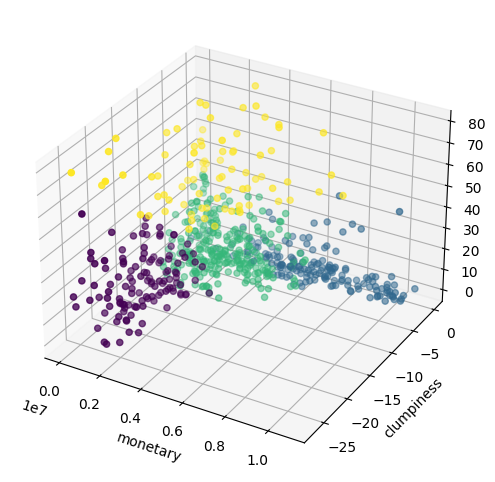

In [50]:

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    rfm_train['monetary'], rfm_train['clumpiness'], rfm_train['recency'], 
    c=rfm_train['cluster_id'],
    cmap='viridis'
)
ax.set_xlabel("monetary")
ax.set_ylabel("clumpiness")
ax.set_zlabel("recency")
plt.show()


## Prediction

In [64]:
cluster_predict = rfm.reset_index(drop=True)
print(cluster_predict.shape)

#Transform
cluster_predict = scaler.transform(cluster_predict)

cluster_predict = pd.DataFrame(cluster_predict, columns=rfm.columns)

cluster_predict.describe()

#Apply kmeans prediction
cluster_predict['cluster_id'] = kmeans.predict(cluster_predict)


#Add the customer id
cluster_predict.index = rfm.index

(918, 4)


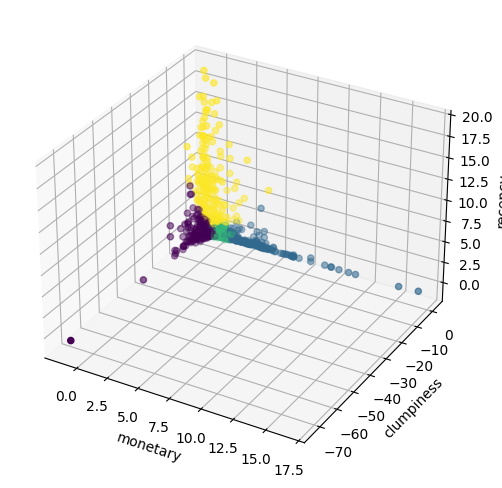

In [65]:

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    cluster_predict['monetary'], cluster_predict['clumpiness'], cluster_predict['recency'], 
    c=cluster_predict['cluster_id'],
    cmap='viridis'
)
ax.set_xlabel("monetary")
ax.set_ylabel("clumpiness")
ax.set_zlabel("recency")
plt.show()

In [67]:

#Merge the dataset
cluster_explore = pd.merge(
    rfm_score.reset_index(), cluster_predict[['cluster_id']].reset_index(), on='customer_id', how='inner'
    )

cluster_id
0    13.549223
1     5.545098
2     9.442379
3    12.796020
Name: rfm_score, dtype: float64

- Cluster 2 is hight frequency high reward but very recent customer (very clumpy) -- new customer at risk
- Cluster 3 are old customers they are regular customers that have not been buying for a few days -- Hybernating
- CLuster 1 are loyalists, they have a low clumpiness but offer low reward becase their monetary value is low -- loyalists
- CLuster 0 are potential loyalists, they have a recent profile but could turn -- new potential loyalists


In [83]:

colors = n_colors('rgb(5, 200, 200)', 'rgb(200, 10, 10)', 4, colortype='rgb')
rfm_factors = ['recency', 'frequency', 'monetary', 'clumpiness', 'rfm_score']

fig = make_subplots(rows=len(rfm_factors), cols=1)
row = 1

for idx, dim in enumerate(rfm_factors):
    for i in range(4):
        fig.add_trace(go.Violin(
            x=cluster_explore[dim][cluster_explore['cluster_id'] == i], line_color=colors[i], 
            showlegend=True if dim == 'recency' else False,
            spanmode='hard'
        ),
         col=1, row=row)

        #Update axis title
        if dim == rfm_factors[0]:
            yaxis_name = 'yaxis'
        else: 
            yaxis_name = f'yaxis{idx+1}'
        fig['layout'][yaxis_name]['title'] = dim.replace('_', ' ')

    #Increment the subplot row number
    row +=1


fig.update_xaxes(showgrid=False, zeroline=False, gridcolor='rgba(220,220,220,1)')
fig.update_yaxes(showgrid=False, zeroline=False, showticklabels=False)
fig.update_traces(orientation='h', side='positive', width=3, points=False, meanline_visible=True)
fig.update_layout(title='RFMC metrics distribution among determined clusters', plot_bgcolor='rgba(0,0,0,0)', height=700) 
fig.show()



In [86]:
#Compute the everage rfmc score per cluster
cluster_explore.groupby('cluster_id')['rfm_score'].mean()

cluster_id
0    13.549223
1     5.545098
2     9.442379
3    12.796020
Name: rfm_score, dtype: float64

## Statistical Analysis

In [87]:
for i in ind_var:
  data = cluster_explore[i]
  stat, p = shapiro(data)

  if p > 0.05:
    print(f'Sample looks Gaussian (fail to reject H0) for variable {i}')
  else:
    print(f'Sample does not look Gaussian (reject H0) for variable {i}')

Sample does not look Gaussian (reject H0) for variable frequency
Sample does not look Gaussian (reject H0) for variable clumpiness
Sample does not look Gaussian (reject H0) for variable monetary
Sample does not look Gaussian (reject H0) for variable recency


We will use a non parametric test, since the normal distrubution assumption cannot be matched

For non-normally distributed data, a common post-hoc test to run after a Kruskal-Wallis test is the Dunn's test for multiple comparisons. The Dunn's test is a non-parametric method for comparing the medians of multiple groups

Upon performing a Kruskal-Wallis Test, we find that the overall p-value is statistically significant, which means the median growth is the not same across the groups. If so, we perform Dunn’s test to determine exactly which groups are different.

In [90]:
for var in ind_var:
    print('--------- Ad Hoc analysis for variable {var} ------------- \n')
    groups = cluster_explore.groupby('cluster_id')[i].apply(list)

    stat, p = stats.kruskal(*groups)

    if p > 0.05:
        print("All groups have the same median (fail to reject H0)")
    else:
        print("Groups have different medians (reject H0)")
        results = sp.posthoc_dunn(groups.to_list(), p_adjust = 'bonferroni')
        print(results)
    print('\n\n')

--------- Ad Hoc analysis for variable {var} ------------- 

Groups have different medians (reject H0)
              1              2             3              4
1  1.000000e+00   4.131592e-15  2.611039e-03   3.532887e-37
2  4.131592e-15   1.000000e+00  3.176465e-06  8.709002e-106
3  2.611039e-03   3.176465e-06  1.000000e+00   1.203234e-67
4  3.532887e-37  8.709002e-106  1.203234e-67   1.000000e+00



--------- Ad Hoc analysis for variable {var} ------------- 

Groups have different medians (reject H0)
              1              2             3              4
1  1.000000e+00   4.131592e-15  2.611039e-03   3.532887e-37
2  4.131592e-15   1.000000e+00  3.176465e-06  8.709002e-106
3  2.611039e-03   3.176465e-06  1.000000e+00   1.203234e-67
4  3.532887e-37  8.709002e-106  1.203234e-67   1.000000e+00



--------- Ad Hoc analysis for variable {var} ------------- 

Groups have different medians (reject H0)
              1              2             3              4
1  1.000000e+00   4.13159